In [8]:
import numpy as np
import keras
import keras.backend as K
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from PIL import Image
import random
import math
import matplotlib.pyplot as plt
import dendropy
import csv
from dendropy.calculate import treecompare
import sys
import numpy
import pickle
from sklearn.model_selection import train_test_split
import string
numpy.set_printoptions(threshold=sys.maxsize)

In [9]:
sys.path.append("../..")

In [10]:
import Bandelt_Encode_Decode.Bandelt_Encode_func as BN_Encode_func
import Bandelt_Encode_Decode.Bandelt_Decode_func as BN_Decode_func
import Bandelt_Encode_Decode.Bandelt_Node as BN

# Loading Data

In [4]:
RF_avg_distance_epoch = np.load('./output/RF_avg_distance_epoch.npy')
val_loss_list_epoch = np.load('./output/val_loss_list_epoch.npy')
loss_list_epoch = np.load('./output/loss_list_epoch.npy')
RF_list_distance_epoch = np.load('./output/RF_list_distance_epoch.npy')

In [5]:
with open('../../ALL_DATA/mapping_dic_dic.npy', 'rb') as input:
    mapping_dic_dic = pickle.load(input)
    
with open('../../ALL_DATA/mapping_dic_dic_decode.npy', 'rb') as input:
    mapping_dic_dic_decode = pickle.load(input)

In [6]:
BRANCH_NUM = 100
SEQUENCE_LEN = 1000

In [7]:
X_Input_Alignment_Data = np.load('../../ALL_DATA/499_dataset_Input_Output/X_Input_Alignment_Data.npy')
Y_Output_BN_List_Data = np.load('../../ALL_DATA/499_dataset_Input_Output/Y_Output_BN_List_Data.npy')
File_Name_List = np.load('../../ALL_DATA/499_dataset_Input_Output/File_Name_List.npy')

# Change Y_Output_BN_List_Data Representation

In [8]:
Y_DENOMINATOR = []
for i in range(100):
    Y_DENOMINATOR.append(i+1)

In [9]:
Y_Output_BN_List_Data = np.true_divide(Y_Output_BN_List_Data, Y_DENOMINATOR)

## Shuffle & Repeat Input Data

In [10]:
X_Input_Alignment_Data_repeat = np.zeros((499*10, 100, 1000, 5))
Y_Output_BN_List_Data_repeat = np.zeros((499*10, 100))
File_Name_List_repeat = np.empty((499*10), dtype='S100')

In [11]:
for i in range(X_Input_Alignment_Data.shape[0]):
    for repeat_idx in range(10):
        shuffle_indices_100 = random.sample(range(0, 100), 100)
        shuffle_indices_1000 = random.sample(range(0, 1000), 1000)
        tmp = X_Input_Alignment_Data[i][shuffle_indices_100]
        tmp = tmp[:, shuffle_indices_1000]
        inner_idx = 10*i + repeat_idx
        X_Input_Alignment_Data_repeat[inner_idx] = tmp
        Y_Output_BN_List_Data_repeat[inner_idx] = Y_Output_BN_List_Data[i]
        File_Name_List_repeat[inner_idx] = File_Name_List[i]

In [12]:
X_Input_Alignment_Data = X_Input_Alignment_Data_repeat
Y_Output_BN_List_Data = Y_Output_BN_List_Data_repeat
File_Name_List = File_Name_List_repeat

In [13]:
print('X_Input_Alignment_Data: ', X_Input_Alignment_Data.shape)
print('Y_Output_BN_List_Data: ', Y_Output_BN_List_Data.shape)
print('File_Name_List: ', File_Name_List.shape)

X_Input_Alignment_Data:  (4990, 100, 1000, 5)
Y_Output_BN_List_Data:  (4990, 100)
File_Name_List:  (4990,)


## Load the Model

In [14]:
def custom_loss_mean_squared_error(y_true, y_pred):
    if not K.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return K.mean(K.square(y_pred*Y_DENOMINATOR - y_true*Y_DENOMINATOR), axis=-1)

In [15]:
model = keras.models.load_model('./output/CNN_model_03.h5', custom_objects={'custom_loss_mean_squared_error':custom_loss_mean_squared_error})

## Plot training and validation loss

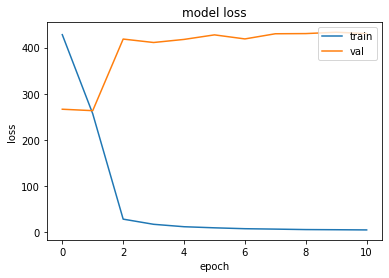

In [16]:
plt.plot(loss_list_epoch)
plt.plot(val_loss_list_epoch)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## X_train plot (Before transformation)

In [17]:
X_train_results = model.predict(X_Input_Alignment_Data_repeat)

In [23]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

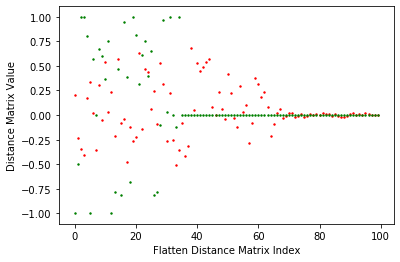

In [24]:
plt.scatter(range(X_train_results[train_show_index].shape[0]), X_train_results[train_show_index], c='r', s = 2)
plt.scatter(range(Y_Output_BN_List_Data[train_show_index].shape[0]), Y_Output_BN_List_Data[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

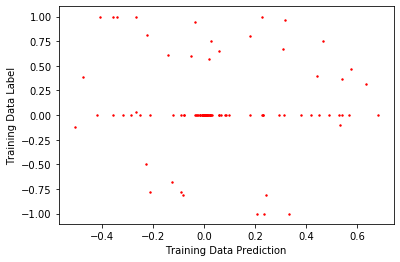

In [25]:
plt.scatter(X_train_results[train_show_index], Y_Output_BN_List_Data[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [30]:
X_train_results_resh= X_train_results.reshape((1, 499*1000))
Y_train_resh = Y_Output_BN_List_Data.reshape((1, 499*1000))

<function matplotlib.pyplot.show(*args, **kw)>

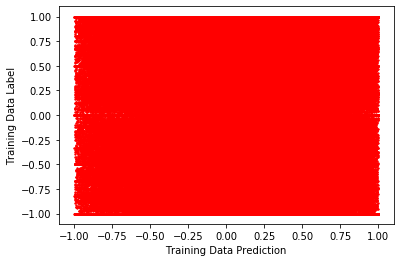

In [31]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## X_train plot (After transformation)

In [28]:
X_train_results_trans = np.around(np.multiply(X_train_results, Y_DENOMINATOR))

In [29]:
Y_train_trans = np.multiply(Y_train, Y_DENOMINATOR)

In [30]:
train_show_index = 0

Text(0, 0.5, 'Distance Matrix Value')

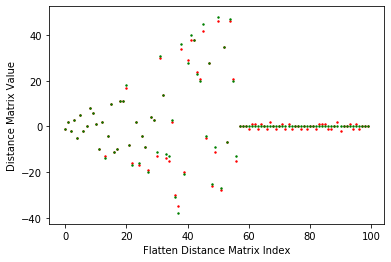

In [31]:
plt.scatter(range(X_train_results_trans[train_show_index].shape[0]), X_train_results_trans[train_show_index], c='r', s = 2)
plt.scatter(range(Y_train_trans[train_show_index].shape[0]), Y_train_trans[train_show_index], c='g', s = 2)
plt.xlabel ('Flatten Distance Matrix Index')
plt.ylabel ('Distance Matrix Value')

<function matplotlib.pyplot.show(*args, **kw)>

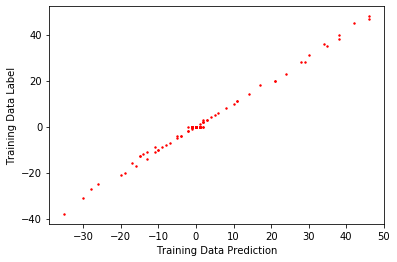

In [32]:
plt.scatter(X_train_results_trans[train_show_index], Y_train_trans[train_show_index], c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

In [33]:
X_train_results_resh= X_train_results_trans.reshape((1, 424*100))
Y_train_resh = Y_train_trans.reshape((1, 424*100))

<function matplotlib.pyplot.show(*args, **kw)>

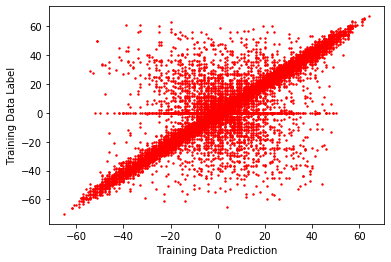

In [34]:
plt.scatter(X_train_results_resh, Y_train_resh, c='r', s = 2)
plt.xlabel ('Training Data Prediction')
plt.ylabel ('Training Data Label')
plt.show

## Plot RF distance

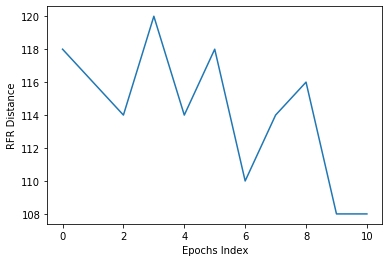

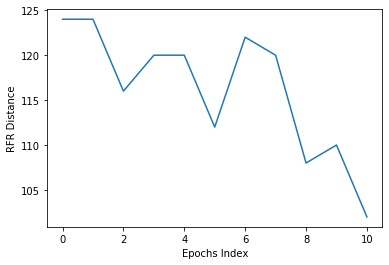

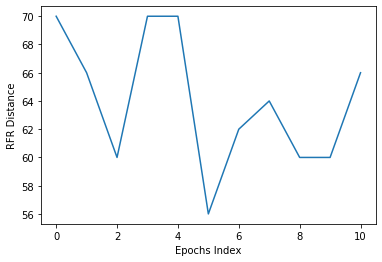

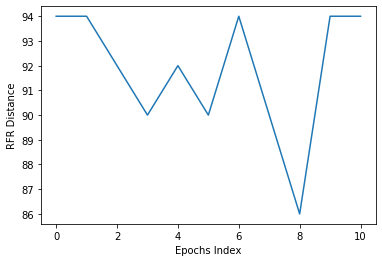

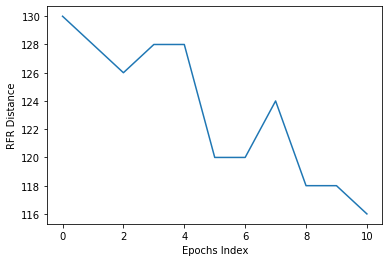

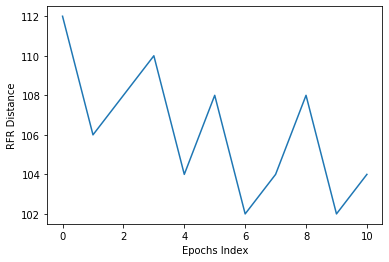

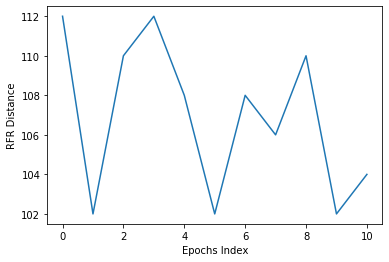

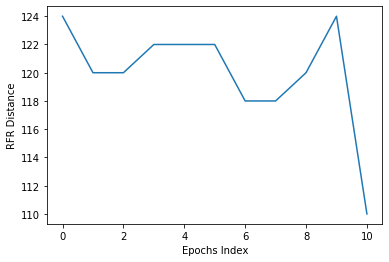

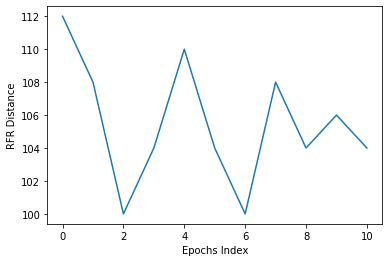

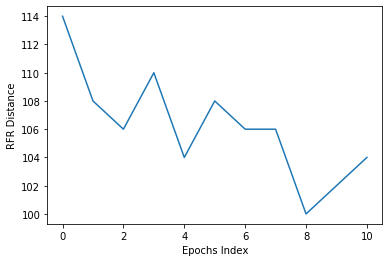

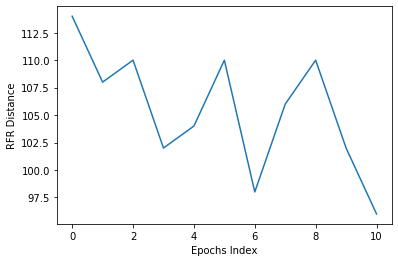

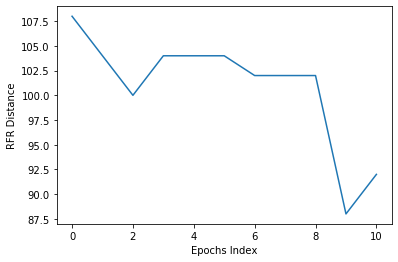

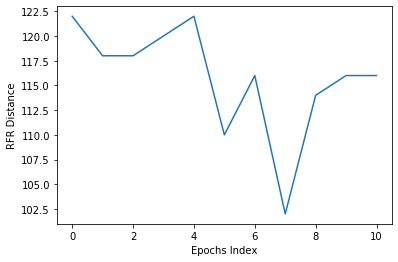

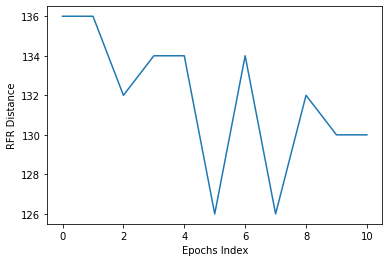

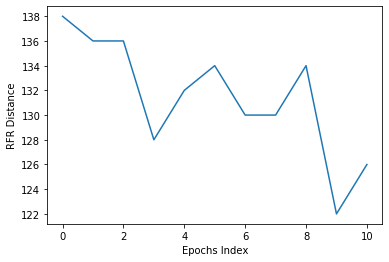

In [32]:
for index in range(15):
    index_RF_dist = [each[index] for each in RF_list_distance_epoch]
    plt.plot(index_RF_dist)
    plt.xlabel ('Epochs Index')
    plt.ylabel ('RFR Distance')
    plt.show()

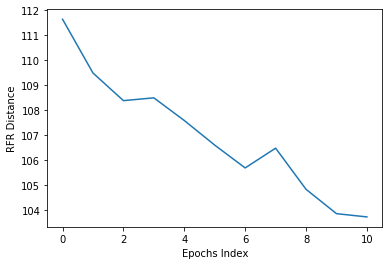

In [33]:
plt.plot(RF_avg_distance_epoch)
plt.xlabel ('Epochs Index')
plt.ylabel ('RFR Distance')
plt.show()